In [1]:
import pandas as pd
import csv
import json
import numpy as np
from tqdm import tqdm
from pyserini.index import IndexReader
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('si-650eecs-549-rankerandroid/documents.csv')
query_data = pd.read_csv('si-650eecs-549-rankerandroid/query_android.csv')
index_reader = IndexReader('si-650eecs-549-rankerandroid/indexes/collection_jsonl')


In [3]:
idx = [i for i in data['id'].unique() if index_reader.doc(str(i))]
len(idx)

22998

In [4]:
terms = {term.term: term.df for term in index_reader.terms()}
len(terms)

41455

In [5]:
dl = {i: len(json.loads(index_reader.doc(str(i)).raw())['contents']) for i in idx if index_reader.doc(str(i))}
len(dl)

22998

In [6]:
avg_dl = np.mean([len(json.loads(index_reader.doc(str(i)).raw())['contents']) for i in idx if
                          index_reader.doc(str(i))])
avg_dl

594.701974084703

In [7]:
df = {term: (index_reader.get_term_counts(term, analyzer=None))[0] for term in terms}
len(df)

41455

In [8]:
tf = {i: index_reader.get_document_vector(str(i)) for i in idx}
len(tf)

22998

In [9]:
N = index_reader.stats()['documents']
N

22998

In [10]:
# postings_list = index_reader.get_postings_list('usb', analyzer=None)
# for posting in postings_list:
#     print(f'docid={index_reader.object.convertLuceneDocidToDocid(index_reader.reader, posting.docid)}, tf={posting.tf}, pos={posting.positions}')


In [11]:
tf_structured = {i: (Counter(index_reader.analyze(json.loads(index_reader.doc(str(i)).raw())['contents'].split('\n')[0])),Counter(index_reader.analyze(json.loads(index_reader.doc(str(i)).raw())['contents'].split('\n')[1]))) for i in idx}
len(tf_structured)

22998

In [12]:
cf = {term: (index_reader.get_term_counts(term, analyzer=None))[1] for term in terms}
len(cf)

41455

In [67]:
cf_sum = np.sum([index_reader.get_term_counts(term, analyzer=None)[1] for term in terms])
cf_sum

1868686

In [46]:
max_cf = 0
for term in terms:
    max_cf = max(max_cf, index_reader.get_term_counts(term, analyzer=None)[1])
max_cf

95646

In [13]:
# 1.55, 0.5, 1.2, 0.25

In [70]:
def score_custom(query, doc_id, k1=1.55, b=0.5, k3=1.2, weight=0.25):
    rank_score = 0

    # get query term frequency
    qtf = Counter(query)

    for word in query:
        if tf[doc_id].get(word):
            rank_score += np.log((N - df.get(word,0) + 0.5)/(df.get(word,0) + 0.5) + (max_cf - cf.get(word,0) + 0.5)/(cf.get(word,0) + 0.5)) * \
                        (k1 + 1) * ((1 + weight) * tf_structured[doc_id][0][word] + (1 - weight) * tf_structured[doc_id][1][word])  / \
                        (k1 * (1 - b + b * dl[doc_id] / avg_dl) + (1 + weight) * tf_structured[doc_id][0][word] + (1 - weight) * tf_structured[doc_id][1][word]) * \
                        (k3 + 1) * qtf[word] / (k3 + qtf[word])

#     print(i,rank_score)
    return rank_score

In [71]:
QueryId = []
DocumentId = []
Score = []
Raw = []
for qid in tqdm(range(query_data.shape[0])):
    analyzed_query = index_reader.analyze(query_data.loc[qid,'Query Description'])
    rel_score = []
    for docid in idx:
        rel_score.append(score_custom(analyzed_query, docid))
    rel_score = np.array(rel_score)
    relevant = np.argsort(rel_score)[::-1][:5]  
    Score += [rel_score[r] for r in relevant]
    Raw += [json.loads(index_reader.doc(str(idx[r])).raw())['contents'] for r in relevant]
    QueryId += [query_data.loc[qid,'QueryId']]*5
    DocumentId += [idx[r] for r in relevant]

100%|██████████| 699/699 [02:44<00:00,  4.26it/s]


In [72]:
test2 = pd.DataFrame({'QueryId':QueryId, 'DocumentId':DocumentId, 'Score':Score, 'Raw':Raw})
test2[:20]

,QueryId,DocumentId,Score,Raw
0,122,4934,63.956909,Access to android usb port from chroot linux?\...
1,122,20927,56.241134,How can i forward USB OTG to Chrooted Ubuntu?\...
2,122,11274,40.860348,"Once you have Ubuntu installed on a Nexus 7, h..."
3,122,10748,38.495629,Can I boot into other OS (such as Ubuntu) from...
4,122,16696,38.027836,Device doesn't mount in Ubuntu 12.04\nI have a...
5,697,19483,19.417259,problem with karbonn a51 internal memory\nmy d...
6,697,15701,17.561933,Karbonn A27 Retina Data Surf Problem?\nI have ...
7,697,18271,17.330328,How to Increase RAM in my karbonn s2\nmy karbo...
8,697,19776,16.880434,problem in mounting sd card in karbonn A4+\nI ...
9,697,15735,16.461407,How To Flash A Rom To China Tablet Karbonn a34...


In [73]:
test2_final = test2[['QueryId','DocumentId']]
test2_final.head(20)

,QueryId,DocumentId
0,122,4934
1,122,20927
2,122,11274
3,122,10748
4,122,16696
5,697,19483
6,697,15701
7,697,18271
8,697,19776
9,697,15735


In [74]:
test2_final.to_csv('part4_result_notebook.csv',index=False)

# Explanation of My Ranking Algorithm

My ranking algorithm makes two improvements on the original BM25 formula. 
- Add weight to TF of documentation title and TF of documentation description. 
- Add collection frequency to the original document frequency.

### Part 1 Weighted TF of document title and description

Suppose we have a document A, whose number of certain term is 0 in title and all in description. For the purpose of experiment, we suppose the frequency to be [0,2,4,6,8,10,12,14]. Another document B, whose number of certain term is half in title and half in description. We suppose the frequency to be [0,1,2,3,4,5,6,7] in title and description respectively. Notice that document A and document B have same total term frequency.

Intuitively, we know that B might have a greater correlation with the query containing that term than A since 
- Title is more important than description.
- If no term occurs in any of the part (title of description), the probability that the document have relationship with the query is low. 

However, in the original BM25 method, they are considered to be the same in ranking score. Hence, we propose the **linear combination of tf of title and description**: 
*tf_new = (1 + weight) * title_tf + (1 - weight) * desc_tf*

It should be noticed that the new formula maintain the property that if title_tf=desc_tf, the score is the same as the original BM25 score, which means that we do not need to re-tune the pre-optimized k1 parameter. Also, when weight=0, the tf_new have no bias towards title_tf and desc_tf, which reduces to the orignal BM25 formula. 

As shown in the following figure, the new structured weighted ranking algorithm performs well on identifying document B as a more correlated document with a higher score.



In [20]:
# Document A
title_tf_A = []
desc_tf_A = np.array([0,2,4,6,8,10,12,14])


# Document B
title_tf_B = np.array([0,1,2,3,4,5,6,7])
desc_tf_B = np.array([0,1,2,3,4,5,6,7])

# let the parameter k1 here be 1.5
score_A = (1.5+1)*0.8*desc_tf_A/(1.5+0.8*desc_tf_A)
score_B = (1.5+1)*(1.2*title_tf_B+0.8*desc_tf_B)/(1.5+(1.2*title_tf_B+0.8*desc_tf_B))


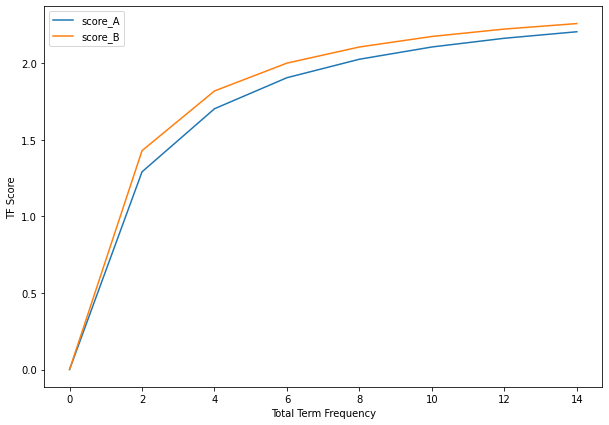

In [21]:
plt.figure(figsize=(10,7))
plt.plot(desc_tf_A, score_A)
plt.plot(title_tf_B+desc_tf_B, score_B)
plt.xlabel('Total Term Frequency')
plt.ylabel('TF Score')
plt.legend(['score_A','score_B'])

Another interesting thing we can get from the above formula is that *(1 + w) * x + (1 - w) * y > x + y* if and only if *x > y* when *w > 0*.

That is to say, if the title frequency is larger than the description frequency and we assume that title is more important than description (w > 0), the resulting score will be higher than baseline (w = 0). On the contrary, if title frequency is smaller than description frequency and we assume that title is more important than description (w>0), the resulting score will be lower than baseline (w = 0).

To illustrate, suppose we have a document C, whose number of certain term is [0,1,2,3,4,5,6] in title and [0,2,4,6,8,10,12] in description. For another document D, whose number of certain term is [0,2,4,6,8,10,12] in title and [0,1,2,3,4,5,6] in description. Notice that document C and document D have same total term frequency.

As shown in the figure, by introduce the weights, we successfully identify document D as a more correlated document and the baseline lies between score of document C and document D.

In [22]:
# Document C
title_tf_C = np.array([1,2,3,4,5,6])
desc_tf_C = np.array([2,4,6,8,10,12])


# Document D
title_tf_D = np.array([2,4,6,8,10,12])
desc_tf_D = np.array([1,2,3,4,5,6])

# let the parameter k1 here be 1.5
tf_base = np.array([1,2,3,4,5,6])

score_without_bias = [(1.5+1)*(1*i+1*2*i)/(1.5+(1*i+1*2*i)) for i in tf_base]
score_C = [(1.5+1)*(1.2*i+0.8*2*i)/(1.5+(1.2*i+0.8*2*i)) for i in tf_base]
score_D = [(1.5+1)*(1.2*2*i+0.8*i)/(1.5+(1.2*2*i+0.8*i)) for i in tf_base]


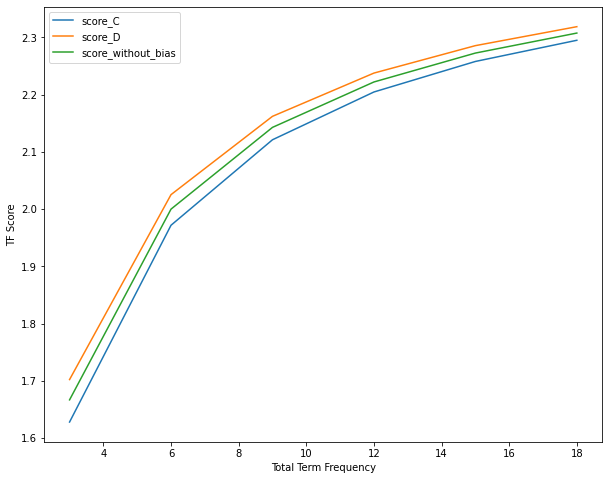

In [23]:
plt.figure(figsize=(10,8))
plt.plot(title_tf_C+desc_tf_C, score_C)
plt.plot(title_tf_D+desc_tf_D, score_D)
plt.plot(title_tf_C+desc_tf_C, score_without_bias)
plt.xlabel('Total Term Frequency')
plt.ylabel('TF Score')
plt.legend(['score_C','score_D','score_without_bias'])

### Part2 Collection frequency added to document frequency

Consider the following case:
- Doc1: ‘who’: 3, “usb”: 2
- Doc2: ‘who’: 10, “usb”: 1

In the original BM25 formula, it is likely that the score of Doc1 of query ‘who use usb’ will be lower than Doc2 since the document frequency for ‘usb’ and ‘who’ are the same and Doc2 has higher term frequency. However, intuitively, we know ‘usb’ is a more informative word, hence higher term frequency of ‘usb’ should result in a higher relevance score.

By taking collection frequency into consideration, although the document frequency for ‘usb’ and ‘who’ are the same, the collection frequency of ‘who’ is much higher than ‘usb’, resulting in a lower score. In this way, the new formula reveals the informativeness of ‘usb’ versus ‘who’.